In [1]:
import re
import pandas as pd
import numpy as np
import os
import missingno as msno

In [2]:
with open("test_iif.iif") as file:
    data_list = file.readlines()

In [3]:
# Examine the raw file to figure out the best way to break it down
print(f">>>This iif file contains {len(data_list)} lines<<<\n")
for i in range(0, 30):
    print(repr(data_list[i]))


>>>This iif file contains 263 lines<<<

'!ACCNT\tNAME\tACCNTTYPE\tDESC\n'
'!CLASS\tNAME\n'
'\n'
'!TRNS\tTRNSID\tDOCNUM\tTRNSTYPE\tDATE\tACCNT\tAMOUNT\tMEMO\tTOPRINT\tNAME\tCLASS\n'
'!SPL\tSPLID\tDOCNUM\tTRNSTYPE\tDATE\tACCNT\tAMOUNT\tMEMO\tCLASS\n'
'!ENDTRNS\n'
'\n'
'ACCNT\tPayroll Expenses:Wages\tEXP\tWage Account - Employee Gross Pay\n'
'ACCNT\tBusiness Checking\tBANK\tChecking Account - Payroll\n'
'ACCNT\tPayroll Liabilities:MO Income Tax\tOCLIAB\tPayee Account - Total Taxes\n'
'ACCNT\tPayroll Liabilities:MO Local Tax\tOCLIAB\tPayee Account - Total Taxes\n'
'ACCNT\tPayroll Liabilities:Federal Unemployment (940)\tOCLIAB\tPayee Account - Total Taxes\n'
'ACCNT\tPayroll Liabilities:Federal Taxes (941/944)\tOCLIAB\tPayee Account - Total Taxes\n'
'ACCNT\tPayroll Liabilities:MO Unemployment Tax\tOCLIAB\tPayee Account - Total Taxes\n'
'ACCNT\tPayroll Expenses:Taxes\tEXP\tTax Account - Employer Taxes\n'
'TRNS\t\t\tCheck\t12/20/2021\tBusiness Checking\t-1622.33\tPay Period: 12/13/2021-12/19/2

In [4]:
# An individual record, starts at 'TRNS', ends at 'ENDTRNS'
for i in range(15,100):
    print(data_list[i])

TRNS			Check	12/20/2021	Business Checking	-1622.33	Pay Period: 12/13/2021-12/19/2021	N	Jean-Luc Picard	

SPL			Check	12/20/2021	Payroll Expenses:Wages	423.08	Gross Pay - This is not a legal pay stub	

SPL			Check	12/20/2021	Payroll Expenses:Taxes	50.62	Employer Taxes	

SPL			Check	12/20/2021	Payroll Liabilities:MO Local Tax	-29.23	MO Local Tax	

SPL			Check	12/20/2021	Payroll Liabilities:MO Unemployment Tax	0.00	MO Unemployment Tax	

SPL			Check	12/20/2021	Payroll Liabilities:Federal Unemployment (940)	0.00	Federal Unemployment (940)	

SPL			Check	12/20/2021	Payroll Liabilities:MO Income Tax	-43.00	MO Income Tax	

SPL			Check	12/20/2021	Payroll Liabilities:Federal Taxes (941/944)	-269.14	Federal Taxes (941/944)	

ENDTRNS

TRNS			Check	12/20/2021	Business Checking	-661.73	Pay Period: 12/13/2021-12/19/2021	N	William Riker	

SPL			Check	12/20/2021	Payroll Expenses:Wages	917.60	Gross Pay - This is not a legal pay stub	

SPL			Check	12/20/2021	Payroll Expenses:Taxes	62.55	Employer Taxes	

S

In [5]:
# Let's get started!
with open("test_iif.iif") as file:
    data = file.read()

In [9]:
# Test by extracting the names. We'll have records for the tax payments as well as the payroll payments.
regex = r"\tN\t(.+)\t\n"
print(re.findall(regex, data))

['Jean-Luc Picard', 'William Riker', 'Geordi La Forge', 'Tasha Yar', 'Worf', 'Beverly Crusher', 'Lwaxana Troi', 'Q', 'The Traveler', 'Jean-Luc Picard', 'William Riker', 'Tasha Yar', 'Worf', 'Q', 'Beverly Crusher', 'Q', 'Lwaxana Troi', 'Geordi La Forge', 'Wesley Crusher', 'The Traveler', 'MO Division of Employment Security', 'IRS', 'MO Department of Revenue', 'IRS', 'IRS', 'IRS', 'MO Department of Revenue', 'IRS', 'IRS', 'IRS', 'IRS', 'IRS', 'MO Department of Revenue', 'IRS', 'IRS', 'IRS', 'IRS', 'MO Division of Employment Security', 'MO Department of Revenue', 'IRS']


In [10]:
def parse_iif(file):
    ''' Takes a string file path/name of an iif format file as input and returns a pandas DataFrame object.
        Requires re, numpy as np, and pandas as pd imports.
        Not a generalized function. Only scrapes for specific regional taxes: Saint Louis, Missouri, US'''
    
    #Make sure dependencies are installed.
    try:
        test = re.findall("t", "test")
    except NameError:
        return "re package not found. Please import it first."
    try:
        test = np.nan
    except NameError:
        return "numpy package not found. Please import it as np."
    try:
        test = pd.DataFrame()
    except NameError:
        return "pandas package not found. Please import it as pd."


    # Read in the data.
    with open(file) as f:
        data = f.read()
    data = data.split("\nTRNS")

    # Create Regular Expression search terms.
    regex_Name = r"\tN\t(.+)\t\n"
    regex_Pay_Period = r"\d+/\d+/\d+-\d+/\d+/\d+"
    regex_Gross_Pay = r"Expenses:Wages\t(\d+\.\d\d)\tGross Pay"
    regex_Employer_Taxes = r"Expenses:Taxes\t(-?\d+\.\d\d)\tEmployer Taxes\t\n"
    regex_MO_Local_Tax = r"Liabilities:MO Local Tax\t(-?\d+\.\d\d)\tMO Local Tax\t\n"
    regex_MO_Unemployment_Tax = r"Payroll Liabilities:MO Unemployment Tax\t(-?\d+\.\d\d)\tMO Unemployment Tax\t\n"
    regex_Federal_Unemployment = r"Payroll Liabilities:Federal Unemployment \(940\)\t(-?\d+\.\d\d)\tFederal Unemployment \(940\)\t\n"
    regex_MO_Income_Tax = "Payroll Liabilities:MO Income Tax\t(-?\d+\.\d\d)\tMO Income Tax\t\n"
    regex_Federal_Taxes = r"Payroll Liabilities:Federal Taxes \(941/944\)\t(-?\d+\.\d\d)\tFederal Taxes \(941/944\)\t\n"

    # A list of columns that will be float type.
    employee_line_items = [regex_Gross_Pay, regex_Employer_Taxes, regex_MO_Local_Tax, regex_MO_Unemployment_Tax, 
                           regex_Federal_Unemployment, regex_MO_Income_Tax, regex_Federal_Taxes]

    # Create empty lists for our column values.
    Name = []
    Pay_Start = []
    Pay_End = []
    Gross_Pay = [] 
    Employer_Taxes = [] 
    MO_Local_Tax = []
    MO_Unemployment_Tax = []
    Federal_Unemployment = []
    MO_Income_Tax = []
    Federal_Taxes = []

    # A list of column names for creating our DataFrame.
    keys = ["Name", "Pay_Start", "Pay_End", "Gross_Pay", "Employer_Taxes", "MO_Local_Tax", 
               "MO_Unemployment_Tax", "Federal_Unemployment", "MO_Income_Tax", "Federal_Taxes"]

    # A list of empty lists to loop through and append.
    buckets = [Name, Pay_Start, Pay_End, Gross_Pay, Employer_Taxes, MO_Local_Tax, 
               MO_Unemployment_Tax, Federal_Unemployment, MO_Income_Tax, Federal_Taxes]

    for i in range(1,len(data)):
        if "GENERAL JOURNAL" not in data[i]:
            name_ = re.findall(regex_Name, data[i])[0]
            Name.append(name_)

            # Scrapes the pay range info and splits it into start and end buckets.
            try:
                pay_period_ = str(re.findall(regex_Pay_Period, data[i])[0])
                start_end = pay_period_.split("-")
                Pay_Start.append(start_end[0])
                Pay_End.append(start_end[1])
            except IndexError:
                Pay_Start.append(np.nan)
                Pay_End.append(np.nan)

            #We've filled the first 3 buckets. Create an index variable starting at 3 and loop through the rest.
            buckets_index = 3
            for item in employee_line_items:
                try:
                    value = float(re.findall(item, data[i])[0])
                    buckets[buckets_index].append(value)
                    buckets_index += 1
                except IndexError:
                    buckets[buckets_index].append(np.nan)
                    buckets_index += 1

    # Create an empty dictionary to prep for our DataFrame, fill it, and create the DataFrame:
    iif_dict = {}
    for key, bucket in zip(keys, buckets):
        iif_dict[key] = bucket
    temp_df = pd.DataFrame(iif_dict)

    # Cast our date columns as DateTime64 objects for ease of analysis.
    temp_df["Pay_Start"] = pd.to_datetime(temp_df["Pay_Start"])
    temp_df["Pay_End"] = pd.to_datetime(temp_df["Pay_End"])

    return temp_df


<AxesSubplot:>

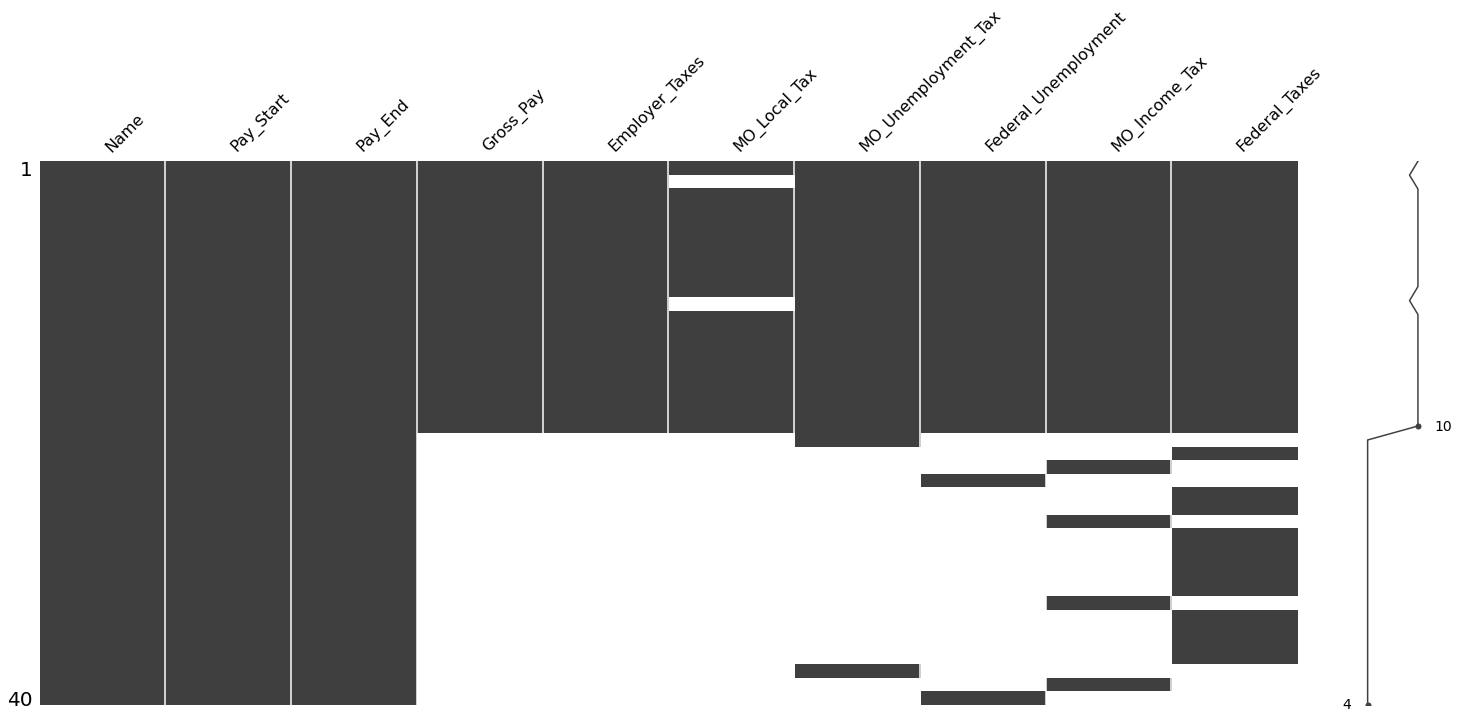

In [12]:
df = parse_iif("test_iif.iif")
msno.matrix(df)

In [13]:
parse_iif("test_iif.iif").head()

,Name,Pay_Start,Pay_End,Gross_Pay,Employer_Taxes,MO_Local_Tax,MO_Unemployment_Tax,Federal_Unemployment,MO_Income_Tax,Federal_Taxes
0,Jean-Luc Picard,2021-12-13,2021-12-19,423.08,50.62,-29.23,0.00,0.00,-43.0,-269.14
1,William Riker,2021-12-13,2021-12-19,917.60,62.55,NaN,0.00,0.00,-38.0,-190.42
2,Geordi La Forge,2021-12-13,2021-12-19,686.93,25.19,-12.87,-31.52,-1.72,-1.0,-88.46
3,Tasha Yar,2021-12-13,2021-12-19,316.50,22.24,-5.17,-2.73,0.00,-11.0,-128.21
4,Worf,2021-12-13,2021-12-19,67.45,7.67,-0.87,-0.46,-0.52,0.0,-13.38


In [16]:
parse_iif("test_iif.iif").tail()

,Name,Pay_Start,Pay_End,Gross_Pay,Employer_Taxes,MO_Local_Tax,MO_Unemployment_Tax,Federal_Unemployment,MO_Income_Tax,Federal_Taxes
35,IRS,2021-12-18,2021-12-21,NaN,NaN,NaN,NaN,NaN,NaN,1330.43
36,IRS,2021-12-25,2021-12-28,NaN,NaN,NaN,NaN,NaN,NaN,1161.51
37,MO Division of Employment Security,2021-10-01,2021-12-31,NaN,NaN,NaN,9476.96,NaN,NaN,NaN
38,MO Department of Revenue,2021-12-01,2021-12-31,NaN,NaN,NaN,NaN,NaN,9614.0,NaN
39,IRS,2021-10-01,2021-12-31,NaN,NaN,NaN,NaN,9241.94,NaN,NaN


In [65]:
#file_list = os.listdir('./Debug/')

In [139]:
#df = parse_iif("./merge/payroll_2016.iif")
# file_list = os.listdir('./merge/')
# df = parse_iif('payroll_2012.iif')
# for file in file_list:
#     path = './merge/'+file
#     _df = parse_iif(path)

#     df = pd.concat([df, _df], ignore_index=True)


(3306, 10)


In [14]:
df.describe()

,Gross_Pay,Employer_Taxes,MO_Local_Tax,MO_Unemployment_Tax,Federal_Unemployment,MO_Income_Tax,Federal_Taxes
count,20.000000,20.000000,18.000000,22.000000,22.000000,24.000000,32.000000
mean,584.542500,37.785000,-7.086667,872.877273,860.927727,1579.291667,2161.490000
std,298.199266,23.244213,7.178045,2834.454080,2790.817259,3642.538717,3856.117553
min,34.000000,6.510000,-29.230000,-31.520000,-4.830000,-43.000000,-273.230000
25%,373.237500,21.592500,-7.867500,-2.015000,-1.687500,-22.500000,-135.477500
50%,680.465000,32.415000,-5.740000,-0.615000,0.000000,-6.500000,-36.615000
75%,839.830000,57.165000,-3.445000,0.000000,0.000000,0.000000,1359.555000
max,935.400000,78.850000,0.000000,9780.850000,9718.780000,9819.000000,9461.900000


In [143]:
# df.to_csv("payroll_complete_2012_2022Q1.csv")